# HOMEWORK 5

In [135]:
import os
os.environ["HTTP_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["HTTPS_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["http_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["https_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["ftp_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128" 

### Training

We can also load in our own dataset and train a model with this data as follows:

In [3]:
!pip install accelerate -U

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Training

How does an LLM improve over time?
We want to compare the probabilitiy distribution for each token generated by our model to the ground truths. 
Our model produces a probability distribution for each token. We want to compare these probability distributions to the ground truths. 
For example, when translating the sentence: “je suis étudiant” into “i am a student” as can be seen in the example:

<img src="images/output_target_probability_distributions.png" alt="Drawing" style="width: 500px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

The model can calculate the loss between the vector it generates and the ground truth vector seen in this example. A commonly used loss function is cross entropy loss:

$CE = -\sum_{x \in X} p(x) log q(x)$

where p(x) represents the true distribution and q(x) represents the predicted distribution.

In [11]:
import torch
from torch import nn
from torch.nn import functional as F
logits = torch.tensor([0.5, 0.1, 0.3])
targets = torch.tensor([1.0, 0.0, 0.0])
loss = F.cross_entropy(logits, targets)
print(loss)

tensor(0.9119)


Another important metric commonly used in LLMs is **perplexity**.

Intuitively, perplexity means to be surprised. We measure how much the model is surprised by seeing new data. The lower the perplexity, the better the training is.

Mathematically, perplexity is just the exponent of the negative cross entropy loss:

$\text{perplexity} = exp(\text{CE})$

In [12]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(2.4891)


In this example, we are using cross entropy loss.

## Let's train a mini-LLM from scratch

### Set up hyperparameters:

In [13]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

### Load in data and create train and test datasets

We're going to be using the tiny Shakespeare dataset. 
Data is tokenized according to a simple character based tokenizer.
Data is split into a train and test set so we have something to test after performing training (9:1 split).

In [14]:
with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

### Set up the components of the Decoder block: 
* MultiHeadAttention
* FeedForward Network

In [15]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


### Combine components into the Decoder block

In [16]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

### Set up the full Transformer model 
This is a combination of the Token embeddings, Positional embeddings, a stack of Transformer blocks and an output block.

In [83]:
# super simple language model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



We will be training a larger LLM on distributed resources in session 6.

## Homework

1. In this notebook, we learned the various components of an LLM. 
    Your homework this week is to take the mini LLM we created from scratch and run your own training loop. Show how the training and validation perplexity change over the steps.
      
    Hint: this function might be useful for you:

### Parameters

In [84]:
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0

### Given Training and Eval function

In [85]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## Testing model - outside of loop

In [86]:
model = LanguageModel()

In [87]:
model.train()
model.cuda();

In [88]:
X,Y = get_batch('train')

In [89]:
logits, loss = model(X,Y)

In [90]:
print(loss)

tensor(4.3678, device='cuda:0', grad_fn=<NllLossBackward0>)


In [91]:
estimate_loss()

{'train': tensor(4.3799), 'val': tensor(4.3811)}

## PART 1

In [92]:
# Create instance of model
model = LanguageModel()
model.cuda();

In [93]:
# Training function
def train_one_epoch(model, optimizer, iters, progress_bar):
    model.train()
    
    # Train in batches
    for batch in range(iters):
        
        X,Y = get_batch('train')
        logits,loss = model(X,Y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        progress_bar.update()

In [94]:
# Adam Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

In [95]:
# Trainig Loop
from tqdm import tqdm

epochs = 7
for epoch in range(epochs):
    
    # Training progress
    with tqdm(total=eval_iters, position=0, leave=True, desc=f"Train Epoch {epoch}") as train_bar:
        train_one_epoch(model, optimizer, eval_iters, train_bar)
    
    # Print out Loss per epoch
    loss_out = estimate_loss()    
    print(loss_out)

Train Epoch 0: 100%|██████████| 200/200 [00:03<00:00, 58.33it/s]


{'train': tensor(2.5228), 'val': tensor(2.5140)}


Train Epoch 1: 100%|██████████| 200/200 [00:03<00:00, 58.42it/s]


{'train': tensor(2.3398), 'val': tensor(2.3563)}


Train Epoch 2: 100%|██████████| 200/200 [00:03<00:00, 58.37it/s]


{'train': tensor(2.2536), 'val': tensor(2.2667)}


Train Epoch 3: 100%|██████████| 200/200 [00:03<00:00, 58.37it/s]


{'train': tensor(2.1646), 'val': tensor(2.1794)}


Train Epoch 4: 100%|██████████| 200/200 [00:03<00:00, 58.33it/s]


{'train': tensor(2.0926), 'val': tensor(2.1305)}


Train Epoch 5: 100%|██████████| 200/200 [00:03<00:00, 58.38it/s]


{'train': tensor(2.0285), 'val': tensor(2.0859)}


Train Epoch 6: 100%|██████████| 200/200 [00:03<00:00, 58.26it/s]


{'train': tensor(1.9970), 'val': tensor(2.0584)}


## PART 2

2. Run the same training loop but modify one of the hyperparameters from this list: 

In [125]:
# hyperparameters
n_embds = [64, 32]
n_heads = [4, 2]
n_layers = 4

Run this at least 4 times with a different value and plot each perplexity over training step. Write a sentence on how the perplexity changed.

In [126]:
# To store loss for each combination
perplexity_train = []
perplexity_val = []
loss_train = []
loss_val = []

epochs = 7

In [127]:
# Trainig Loop
# Run for at least 4 combination of parameters
for n_embd in n_embds:
    for n_head in n_heads:
        
        # Create instance of model
        modelB = LanguageModel()
        modelB.cuda();

        # Adam Optimizer
        optimizer = torch.optim.AdamW(modelB.parameters(), lr=learning_rate)

        for epoch in range(epochs):

            # Training progress
            with tqdm(total=eval_iters, position=0, leave=True, desc=f"Train Epoch {epoch}") as train_bar:
                train_one_epoch(modelB, optimizer, eval_iters, train_bar)

            # Print out Loss per epoch
            loss_out = estimate_loss()
            loss_train.append(torch.exp(loss_out['train']))
            loss_val.append(torch.exp(loss_out['val']))
        
        print('Combination Done')
        perplexity_train.append(loss_train)
        perplexity_val.append(loss_val)
        loss_train = []
        loss_val = []

Train Epoch 6: 100%|██████████| 200/200 [00:03<00:00, 64.34it/s]


Combination Done


Train Epoch 6: 100%|██████████| 200/200 [00:02<00:00, 94.53it/s]


Combination Done


Train Epoch 6: 100%|██████████| 200/200 [00:03<00:00, 64.61it/s]


Combination Done


Train Epoch 6: 100%|██████████| 200/200 [00:02<00:00, 95.30it/s]


Combination Done


In [134]:
perplexity_train[1]

[tensor(7.3689),
 tensor(7.3349),
 tensor(7.3470),
 tensor(7.3792),
 tensor(7.3210),
 tensor(7.4129),
 tensor(7.3972)]

## Comment

I'm not sure where I have a mistake, but even when the model hyperparams and params are the same I get now a different answer than before. I will come back to my answer later to try to debug, but for now, this is my answer.

## Plot

In [129]:
training_steps = range(epochs)

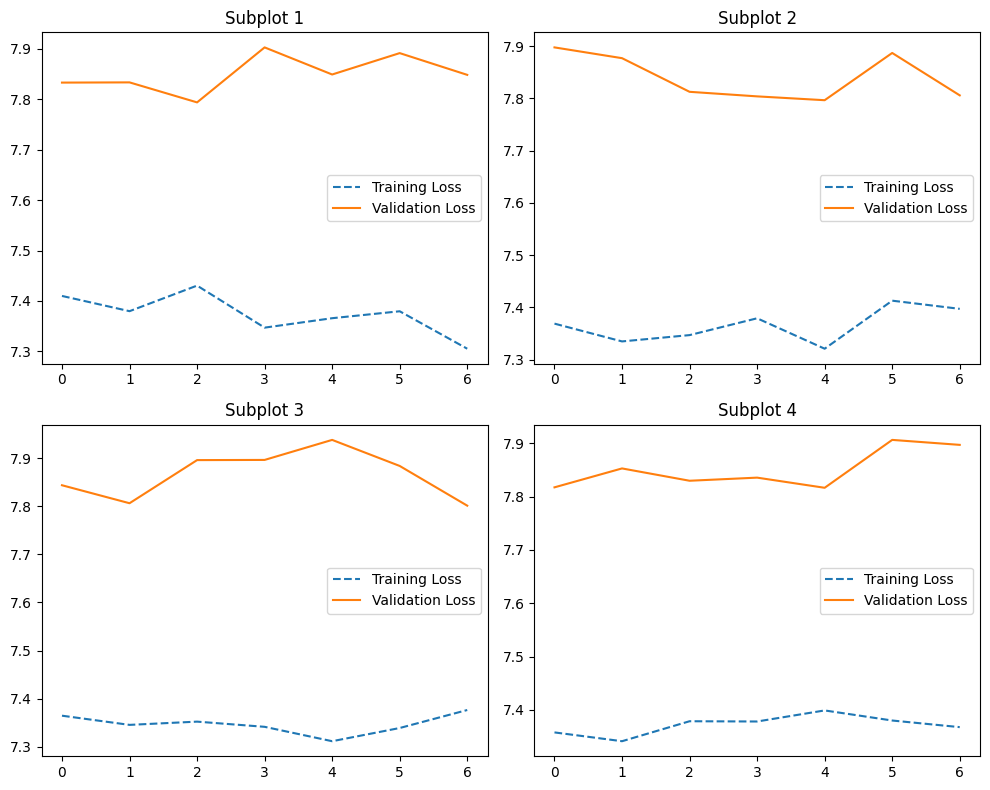

In [133]:
import matplotlib.pyplot as plt

# Specify linestyles
linestyles = ['-', '--']

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Loop through each subplot and plot lines with specified linestyles
for i, ax in enumerate(axs.flat):
    ax.plot(training_steps, perplexity_train[i], linestyle=linestyles[1], label='Training Loss')
    ax.plot(training_steps, perplexity_val[i], linestyle=linestyles[2], label='Validation Loss')
    ax.set_title(f'Subplot {i+1}')
    ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Bonus 1: output some generated text from each model you trained. Did the output make more sense with some hyperparameters than others? 

Bonus 2: We saw a cool visualization of attention mechanisms with BertViz. Take a more complicated model than GPT2 such as "meta-llama/Llama-2-7b-chat-hf" and see how the attention mechanisms are different 

## References

Here are some recommendations for further reading and additional code for review.

* "The Illustrated Transformer" by Jay Alammar
* "Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)"
* "The Illustrated GPT-2 (Visualizing Transformer Language Models)"
* "A gentle introduction to positional encoding"
* "LLM Tutorial Workshop (Argonne National Laboratory)"
* "LLM Tutorial Workshop Part 2 (Argonne National Laboratory)"